# Transfer Learning

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.


1. Set up your data augmentation

2. Define your callbacks (save your model, patience, etc.)

3. Transfer Learning
    
    3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    3.3. Add a top (i.e., the prediction layers)
    
    3.4  Train the model using your dataset
    
    3.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    3.6 If you are satisfied with the train and validation performance go to the next step
    
    3.7 If you are not satisfied with the train and validation performance go back to step 6.1.

4. Test your model on the test set and extract relevant metrics

In [1]:
import tensorflow as tf
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def scale_image(image, scale_type = 'min_max'):
    
    if scale_type == 'min_max':
        img_min = image.min()
        img_max = image.max()
        
        scaled_img = 255 * (image - img_min) / (img_max - img_min)
        
    return scaled_img

def combine_channels(img1, img2, img3):
    full_list = []
    
    for ii in range(img1.shape[0]):
        lst = []
        
        lst.append(scale_image(img1[ii])) #CT
        lst.append(scale_image(img2[ii])) #Dose
        lst.append(scale_image(img3[ii])) #CT+Dose
        
        lst_trans = np.array(lst).transpose()
        full_list.append(lst_trans)

    full_array = np.array(full_list)
    
    return full_array 

def split_features_and_shuffle(X, indices): 
  X = X[indexes]

  train = int(0.7*indexes.size)
  val = int(0.85*indexes.size)

  Xtrain = X[:train]
  Xval = X[train:val]
  Xtest = X[val:]

  return Xtrain, Xval, Xtest


## 1. Import data

In [3]:
wd = '.'

# import images + labels
sag = np.load(wd + '/content/sagittal_set_150.npy')
cor = np.load(wd + '/content/coronal_set_120.npy')
ax = np.load(wd + '/content/axial_set_130.npy')
Y = np.load(wd + '/content/mdadi_labels_binary_oh.npy')

### Import pre-treatment factors

In [4]:
# possibly cleaner way to deal with pre-treatment features
site = np.load(wd + '/content/cancer_site.npy', allow_pickle = True)
alcohol = np.load(wd + '/content/alcohol_intake.npy', allow_pickle = True)
smoking = np.load(wd + '/content/smoking_history.npy', allow_pickle = True)
n_stage = np.load(wd + '/content/n_stage.npy', allow_pickle = True)
t_stage = np.load(wd + '/content/t_stage.npy', allow_pickle = True)

onehotencoder = OneHotEncoder()
site = onehotencoder.fit_transform(site.reshape(-1,1)).toarray()
alcohol = onehotencoder.fit_transform(alcohol.reshape(-1,1)).toarray()
smoking = onehotencoder.fit_transform(smoking.reshape(-1, 1)).toarray()
n_stage = onehotencoder.fit_transform(n_stage.reshape(-1, 1)).toarray()
t_stage = onehotencoder.fit_transform(t_stage.reshape(-1, 1)).toarray()


combined_pretreatment_encoded = np.concatenate((site, alcohol, smoking, n_stage, t_stage), axis=1)
print(combined_pretreatment_encoded.shape)

(133, 22)


### Inspect the Data

In [5]:
bs = 64 # batch size

num_class = int(len(np.unique(Y)))
print(f'Number of classes: {num_class}')

indexes = np.arange(sag.shape[0],dtype = int)
np.random.shuffle(indexes)

# Split and shuffle
Ytrain, Yval, Ytest = split_features_and_shuffle(Y, indexes)
sag_train, sag_val, sag_test = split_features_and_shuffle(sag, indexes)
cor_train, cor_val, cor_test = split_features_and_shuffle(cor, indexes)
ax_train, ax_val, ax_test = split_features_and_shuffle(ax, indexes)
pretreatment_train, pretreatment_val, pretreatment_test = split_features_and_shuffle(combined_pretreatment_encoded, indexes)

print(f"\nPre-treatment dataset")
print(pretreatment_train.shape, pretreatment_val.shape, pretreatment_test.shape)
print(f"\n")

print(f'Training Set:')
print(f'Shape - {sag_train.shape}')
print(f'Class Split - {np.bincount(Ytrain)}\n')

print(f'Validation Set:')
print(f'Shape - {sag_val.shape}')
print(f'Class Split - {np.bincount(Yval)}\n')

print(f'Testing Set:')
print(f'Shape - {sag_test.shape}')
print(f'Class Split - {np.bincount(Ytest)}\n')

Number of classes: 2

Pre-treatment dataset
(93, 22) (20, 22) (20, 22)


Training Set:
Shape - (93, 300, 300, 3)
Class Split - [44 49]

Validation Set:
Shape - (20, 300, 300, 3)
Class Split - [ 6 14]

Testing Set:
Shape - (20, 300, 300, 3)
Class Split - [10 10]



## 2. Define your callbacks (save your model, patience, etc.)

In [6]:
model_name_it = "ct_classifier_en_b0_it.h5"
model_name_ft = "ct_classifier_en_b0_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 3. Transfer Learning

3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

3.3. Add a top (i.e., the prediction layers)

### Create EfficientNet Models for handling our input images

In [7]:
img_height = 300
img_width = 300

# Defining the base, pre-trained model. Load weights pre-trained on ImageNet.
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

In [8]:
# Sagittal - load the model and flatten.
sag_input = tf.keras.layers.Input(shape = (img_height, img_width, 3))
sag_x1 = base_model(sag_input, training = False)
sag_x2 = tf.keras.layers.Flatten()(sag_x1)

# Coronal - load the model, flatten and concatenate to sagittal.
cor_input = tf.keras.layers.Input(shape = (img_height, img_width, 3))
cor_x1 = base_model(cor_input, training = False)
cor_x2 = tf.keras.layers.Flatten()(cor_x1)

# Axial - load the model, flatten and concatenate to sagittal and coronal.
ax_input = tf.keras.layers.Input(shape = (img_height, img_width, 3))
ax_x1 = base_model(ax_input, training = False)
ax_x2 = tf.keras.layers.Flatten()(ax_x1)

# combine our 3 imagenet models
concatenated_images = tf.keras.layers.Concatenate(axis = 1)([sag_x2, cor_x2, ax_x2])

In [9]:
# pre-treatment layer
pretreatment_layer = tf.keras.layers.Input(shape = (pretreatment_train.shape[1],))
pretreatment_flattened = tf.keras.layers.Flatten()(pretreatment_layer)

# combine the pre-treatment layer with the concatenated imagenet layers
images_pretreatment_combined = tf.keras.layers.Concatenate(axis=1)([concatenated_images, pretreatment_flattened])

In [10]:
# Combine the final model
out = tf.keras.layers.Dense(num_class,activation = 'softmax')(images_pretreatment_combined)
model = tf.keras.Model(inputs = [sag_input, cor_input, ax_input,\
                                 pretreatment_layer], outputs = out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb3 (Functional)     (None, 10, 10, 1536) 10783535    input_2[0][0]                    
                                                                

## 3.4 Train the model using your dataset

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit([sag_train, cor_train, ax_train, pretreatment_train], \
                       Ytrain, epochs = 100, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = ([sag_val, cor_val, ax_val, pretreatment_val], Yval))

3/3 [==============================] - 49s 16s/step - loss: 4.4166 - accuracy: 0.5161 - val_loss: 3.8968 - val_accuracy: 0.7000


In [ ]:
# Fine-tuning the model # THIS CELL MIGHT STILL BE MILDLY BROKEN... FREEZES MY COMPUTER, NOT SURE IT IT'S BECAUES A BUG OR MY COMPUTER CAN'T HANDLE IT
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-7),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit([sag_train, cor_train, ax_train, pretreatment_train], \
                       Ytrain, epochs = 20, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = ([sag_val, cor_val, ax_val, pretreatment_val], Yval))


## 4. Test your model on the test set and extract relevant metrics

In [12]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate([sag_test, cor_test, ax_test, pretreatment_test],Ytest)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate([sag_test, cor_test, ax_test, pretreatment_test],Ytest)
print(Ytest)

1/1 [==============================] - 0s 1ms/step - loss: 5.2134 - accuracy: 0.0000e+00


[5.213406562805176, 0.0]

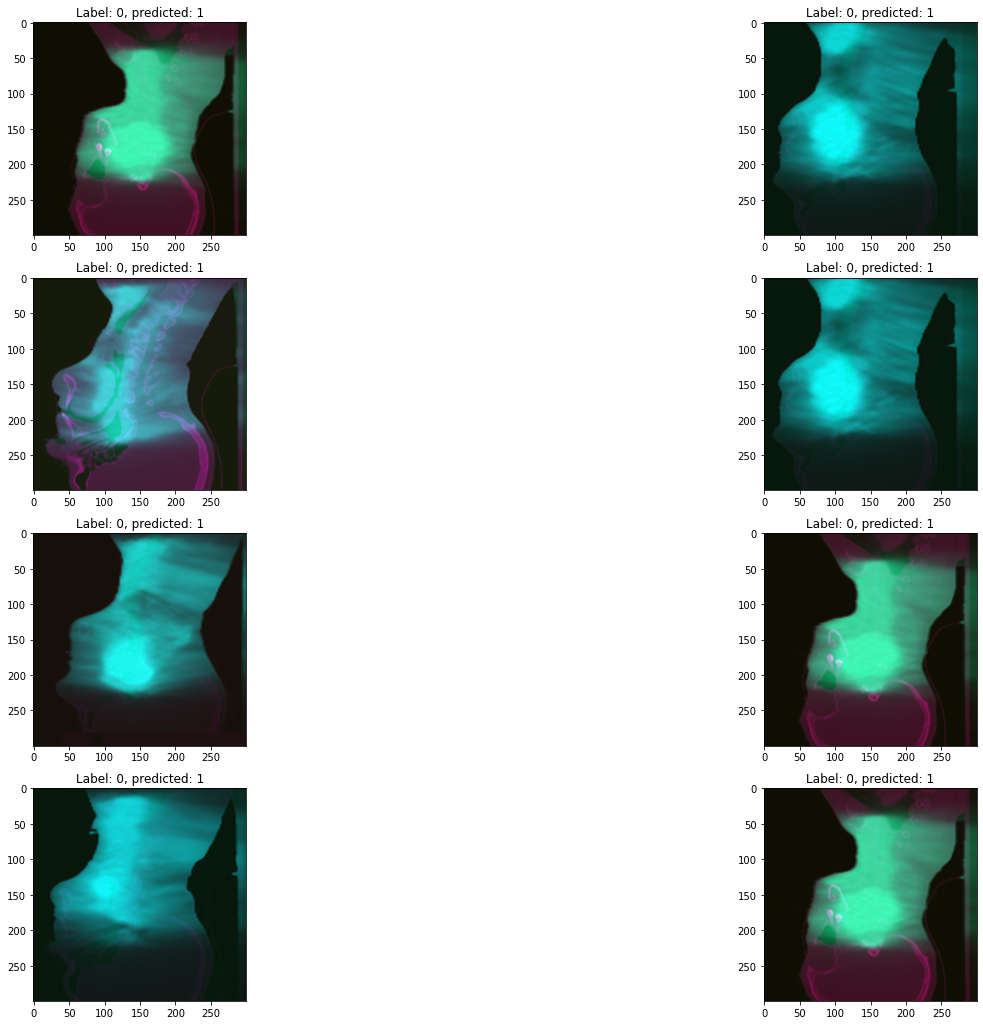

In [13]:
Ypred = model.predict([sag_test, cor_test, ax_test, pretreatment_test]).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = True)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = sag_test[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Ytest[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()